<a href="https://colab.research.google.com/github/ibojovic/LB2_2022/blob/main/SVM_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sklearn
# Import the svm module
from sklearn import svm
import pickle, gzip
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
df_training = pd.read_csv('training_set.tsv',sep = '\t')
df_benchmark = pd.read_csv('benchmark_set.tsv',sep = '\t')

df_benchmark

,UniProtKB accession,Taxa,Kingdom,Class,Sequence (first 50 N-terminal residues),SP cleavage-site annotation
0,Q8TF40,Homo sapiens (Human),Metazoa,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1,Q1ENB6,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2,Q9BZS1,Homo sapiens (Human),Metazoa,NO_SP,MPNPRPGKPSAPSLALGPSPGASPSWRAAPKASDLLGARGPGGTFQ...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3,F4K2A1,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MFAVSIVPRTTSCRLSSAFLCQLSIPLTLRLHHHYQHHQPHLPSPL...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
4,Q9SZL8,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MMDNEVLDFDIGVGVSSGGDVDDDAIDIEHHALDDDDMLDSPIMPC...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
...,...,...,...,...,...,...
7451,O74327,Homo sapiens (Human),Metazoa,NO_SP,MSGYSPLSSGPADVHIGKAGFFSSVINLANTILGAGILSLPNAFTK...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
7452,Q9UM00,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MSTMFADTLLIVFISVCTALLAEGITWVLVYRTDKYKRLKAEVEKQ...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
7453,Q93Y07,Homo sapiens (Human),Metazoa,NO_SP,MELFALLIKVAGLLATVTVGANVVSYSRFRRQNLAKFRSPIDESKE...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
7454,Q86TL2,Mus musculus (Mouse),Metazoa,NO_SP,MQGPAGNASRGLPGGPPSTVASGAGRCESGALMHSFGIFLQGLLGV...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


In [ ]:
# Input data part 1 = creation of vectors
k_list= [20, 22, 24]
c_list = [1, 2, 4]
gamma_list = [0.5, 1, 'scale']
aa_list=['A','Q','L','S','R','E','K','T','N','G','M','W','D','H','F','Y','C','I','P','V'] # define the list of aminoacids


In [ ]:
#Function to calculate the true values
def true_values(df_training):
  '''This function takes the training data after the 5 fold division
    and returns the true 'Class' values in the format 0 or 1'''
  y_true_values = df_training['Class'].tolist()
  for i in range(len(y_true_values)): #create a list of 0 and 1 to perform the prcedure on sklearn
    if y_true_values[i] == 'SP':
      y_true_values[i] = 1
    else:
      y_true_values[i] = 0
  return y_true_values


In [ ]:
#Function to create the list of vectors
def function_vectors(dataframe_iter, k, aa_list):
  '''This function takes a dataframe (training or testing iterations), a value k
  a list of aminoacids and gives back a list of vectors of length k with the percentage of the aminoacid'''
  list_vectors = []
  for sequence in dataframe_iter['Sequence (first 50 N-terminal residues)']:
    vector = [0] * k
    for residue in sequence[0:k]:
      vector[aa_list.index(residue)] += 1
    vector[:] = [x / k for x in vector]
    list_vectors.append(vector)
  return list_vectors


In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from math import sqrt
from sklearn.metrics import accuracy_score



In [ ]:
# three for loops to calculate the values in all the combinations of k, c and gamma
best_mcc = -10000
for c in c_list:
  for gamma in gamma_list:
    for k in k_list:
    # 5 fold division
      mcc_list = []
      precision_list = []
      recall_list = []
      f1_score_list = []
      acc_list=[]

      for validation_fold_n in range(5):


        training_iter = df_training.loc[df_training['Cross-validation fold'] != validation_fold_n]
        test_iter = df_training.loc[df_training['Cross-validation fold'] == validation_fold_n]

        #1 create a list of vectors, each one containing the percentage of that residue
        list_vectors_training = function_vectors(training_iter, k, aa_list)

        #2 Obtain the true values for the training set
        y_true_values = true_values(training_iter)

        #TESTING

        #3 create a list of vectors, each one containing the percentage of that residue
        list_vectors_testing = function_vectors(test_iter, k, aa_list)

        #4 I obtain the true test values
        y_true_test_values = true_values(test_iter)

        #4 define the SVC model with the parameters selected
        mySVC = svm.SVC(C=c, kernel='rbf', gamma=gamma)
        #5 Train the model on the training data
        mySVC.fit(list_vectors_training, y_true_values)
        # Predict classes on testing data
        y_predicted = mySVC.predict(list_vectors_testing)
        #Calculate MCC
        mcc = matthews_corrcoef(y_true_test_values, y_predicted)
        mcc_list.append(mcc)



        #calculate also the other average parameters
        precision = precision_score(y_true_test_values, y_predicted)
        recall = recall_score(y_true_test_values, y_predicted)
        f1_score_value = 2 * (precision * recall) / (precision + recall)
        acc=accuracy_score(y_true_test_values, y_predicted)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score_value)
        acc_list.append(acc)

      #average values
      average_mcc = np.mean(mcc_list)
      average_precision = np.mean(precision_list)
      average_recall = np.mean(recall_list)
      average_f1_score_value = np.mean(f1_score_list)
      avg_acc=np.mean(acc_list)



      #standard errors
      n = 5 #number of elements in the list in which we are doing the mean

      standard_error_mcc = np.std(mcc_list)/sqrt(n)
      standard_error_precision = np.std(precision_list)/sqrt(n)
      standard_error_recall = np.std(recall_list)/sqrt(n)
      standard_error_f1_score_value = np.std(f1_score_list)/sqrt(n)
      se_acc=np.std(acc_list)/sqrt(n)

      if average_mcc > best_mcc:
        best_mcc = average_mcc

        best_k = k
        best_gamma = gamma
        best_c = c

        best_precision = average_precision
        best_recall = average_recall
        best_f1_score = average_f1_score_value
        best_acc=avg_acc

        best_standard_error_mcc = standard_error_mcc
        best_standard_error_precision = standard_error_precision
        best_standard_error_recall = standard_error_recall
        best_standard_error_f1_score_value = standard_error_f1_score_value
        be_se_acc=se_acc

      #print('For the parameters k = {}, gamma = {}, c = {} the mean MCC is {} '.format(k, gamma, c, average_mcc))

print('The highest MCC is {} ± {} obtained with the parameters: k = {}, gamma = {}, c = {} '.format(best_mcc, best_standard_error_mcc, best_k, best_gamma, best_c ))
print('Precision = {} ± {}, Recall = {} ± {} , f1_score = {} ± {}, acc={}±{}'.format(best_precision, best_standard_error_precision, best_recall, best_standard_error_recall, best_f1_score, best_standard_error_f1_score_value,best_acc,be_se_acc ))
        #for each fold we obtain 5 MCC. We make the average of these 5 and we save it as correspondent to that condition.
        #I see which is the tris of parameters with the highest MCC
        #I select those parameters and that MCC for the benchmarking

        # MCC of professor 0.61

The highest MCC is 0.8404905156631308 ± 0.017623928457537137 obtained with the parameters: k = 20, gamma = scale, c = 2 
Precision = 0.876608187134503 ± 0.024157435361663857, Recall = 0.852923076923077 ± 0.015612769769699957 , f1_score = 0.8634027999547499 ± 0.014953133703198208, acc=0.9593797270460979±0.0049775478544622056


### Benchmark

In [ ]:
k = 20
gamma = 'scale'
c = 2

#df_training
#df_benchmark

list_vectors_training_bench = function_vectors(df_training, k, aa_list)

list_vectors_benchmark = function_vectors(df_benchmark, k, aa_list)

y_true_values_training_bench = true_values(df_training)

y_true_values_benchmark = true_values(df_benchmark)

mySVC = svm.SVC(C=c, kernel='rbf', gamma=gamma)
#5 Train the model on all the training data
mySVC.fit(list_vectors_training_bench, y_true_values_training_bench)

y_predicted_benchmark = mySVC.predict(list_vectors_benchmark)

precision_benchmark = precision_score(y_true_test_values, y_predicted)
recall_benchmark = recall_score(y_true_test_values, y_predicted)
f1_score_value_benchmark = 2 * ((precision_benchmark * recall_benchmark) / (precision_benchmark + recall_benchmark))


mcc = matthews_corrcoef(y_true_values_benchmark, y_predicted_benchmark)

#Confusion matrix
conf_matrix = confusion_matrix(y_true_values_benchmark, y_predicted_benchmark)

print('MCC = {}, Precision = {}, Recall = {}, f1_score = {}'.format(mcc, precision_benchmark, recall_benchmark, f1_score_value_benchmark))
print(conf_matrix)

MCC = 0.6135578109702832, Precision = 0.8163265306122449, Recall = 0.8, f1_score = 0.8080808080808082
[[7106  141]
 [  53  156]]


In [ ]:
from sklearn import datasets
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
precision = precision_score(y_true_values_benchmark, y_predicted_benchmark)
recall = recall_score(y_true_values_benchmark, y_predicted_benchmark)
mcc=matthews_corrcoef(y_true_values_benchmark, y_predicted_benchmark)
acc=accuracy_score(y_true_values_benchmark, y_predicted_benchmark)
f1=f1_score(y_true_values_benchmark, y_predicted_benchmark, labels=None, pos_label=1, average='weighted')

print('Precision:',precision)
print('Recall:' ,recall)
print('MCC:',mcc)
print('ACC:',acc)
print('F1:',f1)
print(2 * (precision * recall) / (precision + recall))

Precision: 0.5252525252525253
Recall: 0.7464114832535885
MCC: 0.6135578109702832
ACC: 0.9739806866952789
F1: 0.9761637653336218
0.616600790513834


#Qualitative analysis of the false positives
We have to compare the two rates

Extract from Uniprot the FP and TN in the benchmark.
When there is a transmembrane helix is it more or less likely to predict an SP site?

In [ ]:
df_benchmark_2 = df_benchmark.assign(Prediction = y_predicted_benchmark) # 0 = NO_SP , 1 = SP
# False positives are 'Class' == NO_SP and 'Predicted' == 1
# True negatives are 'Class' == NO_SP and 'Predicted' == 0
# False negatives are 'Class' == SP and 'Predicted' == 0
# True positives are 'Class' == SP and 'Predicted' == 1

In [ ]:
#I first add a new column to the dataframe, containing the prediction made in the benchmarking
false_positives_id = []
df_false_positives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'NO_SP']
df_false_positives = df_false_positives.loc[df_false_positives['Prediction'] == 1]
for id in df_false_positives['UniProtKB accession']:
  false_positives_id.append(id)
false_positives_id

with open("false_positives.txt", "w") as output:
  for item in false_positives_id:
    output.write(str(item)+'\n')

In [ ]:
true_negatives_id = []
df_true_negatives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'NO_SP']
df_true_negatives = df_true_negatives.loc[df_true_negatives['Prediction'] == 0]
for id in df_true_negatives['UniProtKB accession']:
  true_negatives_id.append(id)
true_negatives_id

['Q8TF40',
 'Q1ENB6',
 'Q9BZS1',
 'F4K2A1',
 'Q9SZL8',
 'O82533',
 'Q8UVD9',
 'Q99PF5',
 'Q6EWH2',
 'P53913',
 'O60318',
 'Q7Z7B0',
 'Q6P8X9',
 'P53233',
 'Q8W493',
 'Q05932',
 'O00358',
 'P32614',
 'Q9ASS2',
 'Q9C0B1',
 'Q9UT77',
 'Q9M365',
 'Q8BY35',
 'Q945P0',
 'Q5HY92',
 'Q9LGE3',
 'F4IMQ0',
 'O35943',
 'Q3E7I5',
 'Q6NQJ7',
 'Q5TBA9',
 'O95073',
 'Q75W17',
 'Q9H469',
 'Q9UTG6',
 'Q9CZS3',
 'O43524',
 'Q8W035',
 'Q14331',
 'P42685',
 'Q9UTP3',
 'Q42545',
 'P32785',
 'A2RVV7',
 'Q9P7X3',
 'Q86XJ1',
 'P24522',
 'P14234',
 'Q2V2M9',
 'Q9LT47',
 'O74191',
 'O14276',
 'Q920R4',
 'Q8K3Q3',
 'Q95V55',
 'Q9H334',
 'Q9ZR07',
 'Q07540',
 'Q5SYB0',
 'Q9UQC2',
 'Q15007',
 'P36141',
 'O16850',
 'F4J2K2',
 'O95684',
 'Q96NE9',
 'Q3EBQ3',
 'Q9ZVC9',
 'Q9S793',
 'Q8VZS9',
 'O36024',
 'P40099',
 'Q68CZ1',
 'Q9GPZ7',
 'Q12247',
 'Q8GVZ6',
 'P33893',
 'Q9FWR5',
 'P15442',
 'Q96RT7',
 'O46567',
 'Q9SY66',
 'Q8N4E7',
 'O74972',
 'Q7L622',
 'Q9W3Y4',
 'Q04739',
 'F4JV80',
 'O43716',
 'Q8WUU5',
 'Q84P53',

In [ ]:
#false positive rate
len(false_positives_id)
total_negatives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'NO_SP']
len(total_negatives)
false_positive_rate = len(false_positives_id)/len(total_negatives)
false_positive_rate

0.019456326755898992

In [ ]:
total_negatives_id = []
total_negatives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'NO_SP']
for id in total_negatives['UniProtKB accession']:
  total_negatives_id.append(id)
total_negatives_id

with open("total_negatives.txt", "w") as output:
  for item in total_negatives_id:
    output.write(str(item)+'\n')


In [ ]:


#False positives

#Von Henje
#averall false positive rate 2%
#FPR of transmembrane 29%
#FPR of Transit peptide 4%

#SVM
#averall false positive rate 2%
#FPR of transmembrane 28%
#FPR of Transit peptide 4%

#These type of signal, in particular transmembrane should be treated properly to avoid the overprediction.

#False Negatives

#Von Henje

In [ ]:
#code to get from the uniprot file the elements
false_positives_uniprot = open('false_positives_uniprot.tsv', 'r')
tm_evidence = {}
eco_set = ['ECO:0000269','ECO:0000303','ECO:0000305','ECO:0000250','ECO:0000255','ECO:0000255','ECO:0000312','ECO:0007744']
tm_proteins = set([])
for line in false_positives_uniprot:
  line = line.strip().split('\t')
  if len(line) > 2:
    acc = line[0]
    tm_field = line[2]
    if tm_field != '':
      in_tm = False
      for k in tm_field.split():
        if k == 'TRANSMEM':
          in_tm = True
        elif k.startswith('/note'):
          pass
        elif k.startswith('/evidence'):
          for eco in eco_set:
            if acc not in tm_evidence:
              tm_evidence[acc] = set([])
            tm_evidence[acc].add(eco)
        else:
          if in_tm == True:
            if '..' in k:
              i = k.split('..')[1]
              i = i.replace(';', '')
              if int(i) <= 50:
                tm_proteins.add(acc) #tm_proteins contains all the uniprot accession number with transmembrane in the first 50 residues
#for acc in tm_proteins:
len(tm_proteins)


39

In [ ]:
#code to get from the uniprot file the elements
total_negatives_uniprot = open('total_negatives_uniprot.tsv', 'r')
tm_evidence_total = {}
eco_set = ['ECO:0000269','ECO:0000303','ECO:0000305','ECO:0000250','ECO:0000255','ECO:0000255','ECO:0000312','ECO:0007744']
tm_proteins_total = set([])
for line in total_negatives_uniprot:
  line = line.strip().split('\t')
  if len(line) > 2:
    acc = line[0]
    tm_field = line[2]
    if tm_field != '':
      in_tm = False
      for k in tm_field.split():
        if k == 'TRANSMEM':
          in_tm = True
        elif k.startswith('/note'):
          pass
        elif k.startswith('/evidence'):
          for eco in eco_set:
            if acc not in tm_evidence_total:
              tm_evidence_total[acc] = set([])
            tm_evidence_total[acc].add(eco)
        else:
          if in_tm == True:
            if '..' in k:
              i = k.split('..')[1]
              i = i.replace(';', '')
              if int(i) <= 50:
                tm_proteins_total.add(acc) #tm_proteins contains all the uniprot accession number with transmembrane in the first 50 residues

tm_proteins_total_annotated = []
for id in tm_proteins_total:
  if id in tm_evidence_total.keys():
    tm_proteins_total_annotated.append(id)
len(tm_proteins_total_annotated)




141

In [ ]:
#Calculating the ratio of false positives that have a transmembrane
len(tm_proteins)/len(tm_proteins_total_annotated)

0.2765957446808511

#Calculating the ratio for the transit peptide

In [ ]:
#code to get from the uniprot file the elements
false_positives_uniprot = open('false_positives_uniprot.tsv', 'r')
transit_evidence_total = {}
transit_proteins_total = set([])

eco_set = ['ECO:0000269','ECO:0000303','ECO:0000305','ECO:0000250','ECO:0000255','ECO:0000255','ECO:0000312','ECO:0007744']

for line in false_positives_uniprot:
  line = line.strip().split('\t')
  if len(line) > 3:
    acc = line[0]
    transit_field = line[3]
    if transit_field != '':
      for k in transit_field.split():
        if k == 'TRANSIT':
          transit_proteins_total.add(acc) #all proteins with transit peptide
        elif k.startswith('/evidence'):
          for eco in eco_set:
            if acc not in transit_evidence_total:
              transit_evidence_total[acc] = set([])
            transit_evidence_total[acc].add(eco)

#len(transit_Mitochondrion_id) #795
#len(transit_Chloroplast_id)
#len(transit_Peroxisome_id)

transit_proteins_positives = []
for id in transit_proteins_total:
  if id in transit_evidence_total.keys():
    transit_proteins_positives.append(id)

len(transit_proteins_positives)




47

In [ ]:
#code to get from the uniprot file the elements
total_negatives_uniprot = open('total_negatives_uniprot.tsv', 'r')
transit_evidence_total = {}
transit_proteins_total = set([])

eco_set = ['ECO:0000269','ECO:0000303','ECO:0000305','ECO:0000250','ECO:0000255','ECO:0000255','ECO:0000312','ECO:0007744']

for line in total_negatives_uniprot:
  line = line.strip().split('\t')
  if len(line) > 3:
    acc = line[0]
    transit_field = line[3]
    if transit_field != '':
      for k in transit_field.split():
        if k == 'TRANSIT':
          transit_proteins_total.add(acc) #all proteins with transit peptide
        elif k.startswith('/evidence'):
          for eco in eco_set:
            if acc not in transit_evidence_total:
              transit_evidence_total[acc] = set([])
            transit_evidence_total[acc].add(eco)

#len(transit_Mitochondrion_id) #795
#len(transit_Chloroplast_id)
#len(transit_Peroxisome_id)

transit_proteins_negatives = []
for id in transit_proteins_total:
  if id in transit_evidence_total.keys():
    transit_proteins_negatives.append(id)

transit_proteins_negatives


['Q08230',
 'Q9M0S5',
 'P53123',
 'P87109',
 'Q9STG9',
 'F4JLC1',
 'P82919',
 'Q9JIQ3',
 'Q8L9A0',
 'O74988',
 'Q10215',
 'O64894',
 'Q9C667',
 'Q66GR6',
 'Q84JL2',
 'Q9C9L4',
 'Q8LBK6',
 'Q6P4F2',
 'Q32PI8',
 'A3C6G9',
 'P97478',
 'Q9SEL7',
 'Q9SAK4',
 'O22779',
 'Q09785',
 'Q94AR8',
 'Q94A82',
 'F4I7I0',
 'Q8VY26',
 'Q9FIF7',
 'Q9LE95',
 'Q2HJF1',
 'Q08742',
 'Q7L8L6',
 'Q9FNM5',
 'Q10439',
 'A8MS68',
 'Q93VC7',
 'Q9MA15',
 'B8XA40',
 'Q75HZ9',
 'Q8VY09',
 'Q9LVI9',
 'Q9SCY2',
 'Q0WPT7',
 'Q50EK2',
 'O74890',
 'O65271',
 'Q9USL7',
 'Q6NPF9',
 'Q2YDF6',
 'Q9MBA2',
 'Q64380',
 'Q99NB1',
 'O48721',
 'Q94B52',
 'P46681',
 'Q949Q5',
 'Q653T6',
 'Q05863',
 'Q9C8J6',
 'Q9SJW9',
 'Q8W487',
 'Q93Y52',
 'O74317',
 'Q9XEA0',
 'Q16740',
 'Q84RQ7',
 'Q8VYJ7',
 'Q9FKG3',
 'O35943',
 'Q04599',
 'P32387',
 'Q5XF06',
 'P70584',
 'Q67Y99',
 'Q9HC36',
 'Q9SRE0',
 'Q9SX99',
 'Q9FZ89',
 'Q9SCL7',
 'P0CV95',
 'P53163',
 'Q9FYR6',
 'P36526',
 'Q9UT03',
 'P08067',
 'Q9SAC6',
 'Q8W4I6',
 'Q5T440',
 'Q9LYT7',

In [ ]:
len(transit_proteins_positives)/len(transit_proteins_negatives)

0.035153328347045626

For the VH we performed the average, so we report the average.
For the SVM we tested multiple combination and we put in the table the performance of the best model
In both cases I calculate a standard error as the standard deviation/number of samples(5)

For the next step we will use the data in the benchmarking set. They are 7k.
209 have a signal peptide, the others do not have it.
We will analyze the false negatives and false positives. The predictions should be stored: we have to store something that says 'according to SVM this protein is predicted as negative'.
From the false positive we can derive the false positive rate. It is equal to False positives/(false positives+true negatives). It has to be as little as possible.

- All negative examples (False positive + True negatives)
a) retrieve Trans membrane proteins in particular those haveing a Trans Membrane alpha helix in the first 50 residues (#TM)
FP/#TM (the FP is elevated to TM, but I don't understand if it is an error)
b) transit peptides are directing proteins to
mitochondria TP  
chloroplastic TP
peroxisomal TP  

Create a text file with all the negative (true negatives and false positives) IDs and use the ID mapping tool onon Uniprot

We ignore the the automatic annotations, we consider only the manual annotations.


#False Negatives
Why did we miss some signal peptides? It should be something related to the method. We could check if the assumptions we made are not true for the False Negatives.
We take the false negatives and for the
Von Hejne method we can compute a logo (-13,+2) and another logo (of all the positives). In the first logo something should miss, there should some differences.

Testare i k residui come proprietà predittiva
Confrontare composizione dei primi k residui sui true positives con quella dei false negatives e confrontarla con i reali positivi. LA dirstribuzione dei training set è più simile alla distribuzione dei true positive, rispetto a quella dei negative

In [ ]:
df_benchmark_2

df_false_negatives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'SP']
df_false_negatives = df_false_negatives.loc[df_false_negatives['Prediction'] == 0]

df_true_positives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'SP']
df_true_positives = df_true_positives.loc[df_true_positives['Prediction'] == 1]


In [ ]:
import matplotlib.pyplot as plt


(0.0, 40.0)

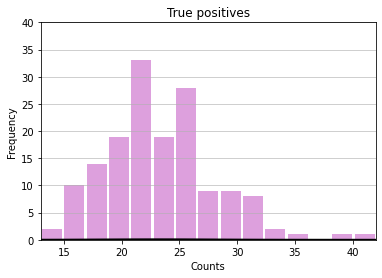

In [ ]:
#Calculate the length of false positives and true positives

import scipy.stats as stats

# plot the histogram of count_true_positives
count_true_positives.plot.hist(grid=False, bins=15, rwidth=0.9, color='plum')
plt.title('True positives')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# fit a normal distribution to the histogram data
mu, std = stats.norm.fit(count_true_positives)
x = np.linspace(count_true_positives.min(), count_true_positives.max(), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# adjust the range of the x-axis and y-axis
plt.xlim(count_true_positives.min(), count_true_positives.max())
plt.ylim(0, 40)




#the median should be similar to the training one, a bit over 20. For the false


Mean =  23.173076923076923


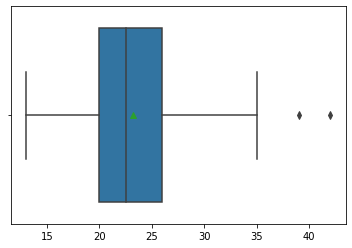

In [ ]:
sns.boxplot(x=count_true_positives, showmeans = True)
print('Mean = ', count_true_positives.mean())

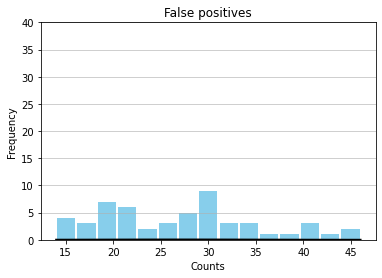

In [ ]:

count_false_positives = df_false_negatives['SP cleavage-site annotation'].str.count('S').tolist()
count_false_positives = pd.Series(count_false_positives)

count_false_positives.plot.hist(grid=False, bins=15, rwidth=0.9,
                   color='skyblue')
plt.title('False positives')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0, top=40)

# fit a normal distribution to the histogram data
mu, std = stats.norm.fit(count_false_positives)
x = np.linspace(count_false_positives.min(), count_false_positives.max(), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

Mean =  27.20754716981132


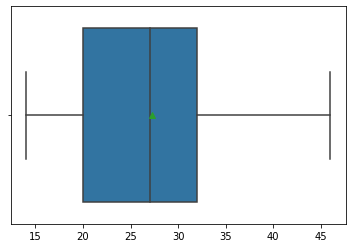

In [ ]:
sns.boxplot(x=count_false_positives, showmeans = True)
print('Mean = ', count_false_positives.mean())

#Calculate the different composition of false negatives compared to the true positives

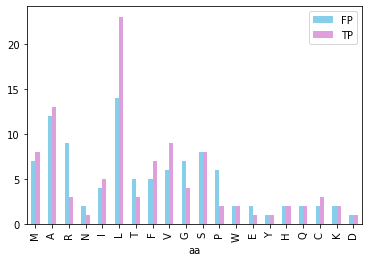

In [ ]:
#usare seaborn

k = 20

def char_frequency(str1):
    dict = {}
    for n in str1:
        keys = dict.keys()
        if n in keys:
            dict[n] += 1
        else:
            dict[n] = 1
    return dict

df_training = pd.read_csv('training_set.tsv',sep = '\t')
df_training_positives = df_training.loc[df_training['Class'] == 'SP']

s_training_positives= df_training_positives.iloc[:,5].values.tolist() #here 5 and not 4 because there is the cross validation index

s_training_positives= [item[0:20] for item in s_training_positives]
sequence_training_positives=''.join(s_training_positives)





df_benchmark_2 = df_benchmark.assign(Prediction = y_predicted_benchmark) # 0 = NO_SP , 1 = SP

df_false_negatives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'SP']
df_false_negatives = df_false_negatives.loc[df_false_negatives['Prediction'] == 0]

df_true_positives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'SP']
df_true_positives = df_true_positives.loc[df_true_positives['Prediction'] == 1]


s_false_positives= df_false_negatives.iloc[:,4].values.tolist()
s_false_positives= [item[0:20] for item in s_false_positives]
sequence_false_positives=''.join(s_false_positives)
sequence_false_positives

s_true_positives = df_true_positives.iloc[:,4].values[1:20].tolist()
s_true_positives= [item[0:20] for item in s_true_positives]
sequence_true_positives=''.join(s_true_positives)

false_frequence = char_frequency(sequence_false_positives)
true_frequence = char_frequency(sequence_true_positives)
training_true_frequence = char_frequency(sequence_training_positives)

##Continue from here

for key in false_frequence.keys():
    false_frequence[key]=float(round((false_frequence[key]/len(sequence_false_positives))*100))

for key in true_frequence.keys():
    true_frequence[key]=float(round((true_frequence[key]/len(sequence_true_positives))*100))

for key in training_true_frequence.keys():
    training_true_frequence[key]=float(round((training_true_frequence[key]/len(sequence_training_positives))*100))

df_false = pd.DataFrame(list(false_frequence.items()),columns = ['aa','prctg'])
df_true = pd.DataFrame(list(true_frequence.items()),columns = ['aa','prctg'])
df_training_true = pd.DataFrame(list(training_true_frequence.items()),columns = ['aa','prctg'])

df = pd.merge(df_false, df_true,on='aa')
df.columns=['aa','FP','TP']

df.set_index('aa').plot.bar(color=['skyblue','plum'])

#There is abundance of arginin. Charged residues should be under represented in the signal peptide. The abundance of arginin
#makes the model decide for the negatives, because it expects to see those residues not in the signa peptide
#Leucin is very abundant in the signal peptide, it is expected to be seen in the signal peptide therefore not finding it makes the model tend for the false positive.
#Other things in the recording of the lectures

#Plot also the real positives from the training set. In particular for the von henje is important

In [ ]:
df_training_true

,aa,prctg
0,M,7.0
1,R,3.0
2,F,6.0
3,L,24.0
4,A,12.0
5,T,4.0
6,S,7.0
7,Q,2.0
8,E,2.0
9,G,5.0


We have to plot the percentage of each reign

And in the svm for false negatives the 85% is for metazoa

Plotting the Kingdom of false positives and false negatives, to see if some of them are over represented


In [ ]:
df_benchmark_2 = df_benchmark.assign(Prediction = y_predicted_benchmark) # 0 = NO_SP , 1 = SP

df_false_negatives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'SP']
df_false_negatives = df_false_negatives.loc[df_false_negatives['Prediction'] == 0]

df_false_positives = df_benchmark_2.loc[df_benchmark_2['Class'] == 'NO_SP']
df_false_positives = df_false_positives.loc[df_false_positives['Prediction'] == 1]


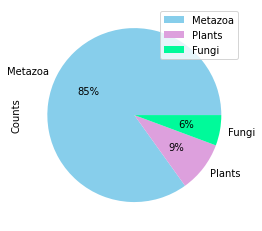

In [ ]:
##Pie plot according to the kingdom
df_false_negatives['Counts'] = np.zeros(len(df_false_negatives))
grp_df_false = df_false_negatives.groupby('Kingdom').count()
grp_df_false = grp_df_false.sort_values(by='Counts',ascending=False)
grp_df_false = grp_df_false.drop(grp_df_false.columns[[1, 2,3,4,5,6]], axis=1)
grp_df_false.columns=['Counts']
grp_df_false.plot(kind='pie', y='Counts', autopct='%.0f%%',colors=['skyblue','plum','mediumspringgreen','bisque','lightcoral'])

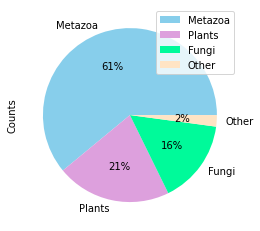

In [ ]:
##Pie plot according to the kingdom
df_false_positives['Counts'] = np.zeros(len(df_false_positives))
grp_df_false_positives = df_false_positives.groupby('Kingdom').count()
grp_df_false_positives = grp_df_false_positives.sort_values(by='Counts',ascending=False)
grp_df_false_positives = grp_df_false_positives.drop(grp_df_false_positives.columns[[1, 2,3,4,5,6]], axis=1)
grp_df_false_positives.columns=['Counts']
grp_df_false_positives.plot(kind='pie', y='Counts', autopct='%.0f%%',colors=['skyblue','plum','mediumspringgreen','bisque','lightcoral','pink'])